In [1]:
import gfc
from gfc import *
import numpy as np
import scipy as sp
from scipy.stats import chi2
import copy as cp
from extreme_deconvolution import extreme_deconvolution as xd
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import gridspec as gs
from matplotlib.patches import Ellipse
import matplotlib as mpl
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import Angle
from pygaia.astrometry.vectorastrometry import phaseSpaceToAstrometry, astrometryToPhaseSpace, sphericalToCartesian, normalTriad
from pygaia.astrometry.coordinates import CoordinateTransformation, Transformations
from pygaia.astrometry import constants

galtoicrs = CoordinateTransformation(Transformations.GAL2ICRS)
icrstogal = CoordinateTransformation(Transformations.ICRS2GAL)

rc('font',**{'family':'serif', 'serif':['Times']})
rc('text', usetex=True)

root_folder = "/disks/strw9/vanweenen/mrp1/results/simulation"

def total_simulation(meanstep, sigma, p, q):
    # Simulate a collection of stars distributed at constant space density around the sun, 
    # with distances between 1 and 500 pc. Use Galactic coordinates. Each star is assigned
    # a 3D space velocity drawn from a superposition of several 3D normal distributions in 
    # velocity space.
    rmin = 1. #pc
    rmax = 500. #pc
    N = 1000 #nr of stars
    
    K = 2 #nr of components
    
    r = np.random.uniform(rmin**3, rmax**3, N)**(1./3.) #pc
    theta = np.arccos(np.random.uniform(-1, 1, N))-np.pi/2
    phi = np.random.uniform(0, 2*np.pi, N)

    x_gal,y_gal,z_gal = sphericalToCartesian(r, phi, theta)
    
    # Define the space velocities (u,v,w), again in galactic coordinates

    wmin = 0.5 ; wmax=30 ; wstep=1.5
    #wmin = 0.5 ; wmax=5 ; wstep=.25
    Kmin=1 ; Kmax=10 ; Kstep=1

    def simulate_amps(k):
        a = np.empty([k])
        rest = 1
        for i in range(k-1):
            a[i] = (1./k)/(i+2)**p
            rest -= a[i]
        a[k-1] = rest
        return a

    def simulate_means(k):
        m = np.empty([k, 3])
        for i in range(k):
            m[i,:] = [meanstep*i, meanstep*i, meanstep*i]
        return m

    def simulate_covs(k):
        c = np.zeros((k,3,3))
        for i in range(k):
            c[i,0,0] = (sigma/((i+1)**q))**2
            c[i,1,1] = (sigma/((i+1)**q))**2
            c[i,2,2] = (sigma/((i+1)**q))**2
        return c

    initamps = []
    initmeans = []
    initcovs = []

    for k in range(Kmin, Kmax+1):
        initamps.append(simulate_amps(k))
        initmeans.append(simulate_means(k))
        initcovs.append(simulate_covs(k))

    print initamps[K-1], initmeans[K-1], initcovs[K-1]

    # Simulate velocity for every star
    component = np.random.choice(K, N, p=initamps[K-1]) #choose component
    uvw_gal = np.empty([N,3])
    for i in range(N):
        uvw_gal[i] = np.random.multivariate_normal(initmeans[K-1][component[i],:], initcovs[K-1][component[i],:,:])

    #uvwcov_gal = np.zeros_like(uvw_gal) #use this when not using astrometry coordinate transformation
    
    # Transform the simulated positions and velocities into astrometric observables and radial velocity in ICRS
    print "Transformation to astrometric observables.."
    x_icrs, y_icrs, z_icrs = galtoicrs.transformCartesianCoordinates(x_gal, y_gal, z_gal)
    u_icrs, v_icrs, w_icrs = galtoicrs.transformCartesianCoordinates(uvw_gal[:,0], uvw_gal[:,1], uvw_gal[:,2])
    alpha, delta, parallax, mura, mudec, vrad = phaseSpaceToAstrometry(x_icrs, y_icrs, z_icrs, u_icrs, v_icrs, w_icrs) #rad, rad, mas, mas/yr, mas/yr, km/s
    astr_true = np.column_stack((alpha, delta, parallax, mura, mudec, vrad))

    print "Simulate measured values.."
    #Simulate measured values using measurement errors
    measurement_error = np.array([0.,0.,0.3,1.,1.,0])
    measurement_covar = np.diag(measurement_error**2) #measurement errors
    astr_measured = np.empty([N,6])
    for i in range(N):
        astr_measured[i] = np.random.multivariate_normal(astr_true[i,:], measurement_covar, 1)
    errors_measured = np.tile(measurement_error, (N,1))
    corr_measured = np.tile(np.tile([0.],15), (N,1))

    arr_astr = np.column_stack((astr_measured, errors_measured, corr_measured))
    labels = ('ra', 'dec', 'parallax', 'pmra', 'pmdec', 'vrad', 'ra_error', 'dec_error', 'parallax_error', 'pmra_error', 'pmdec_error', 'vrad_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'ra_vrad_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'dec_vrad_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'parallax_vrad_corr', 'pmra_pmdec_corr', 'pmra_vrad_corr', 'pmdec_vrad_corr')
    t_astr=Table(arr_astr, names=labels)
    
    print "Projection.."
    # Calculate the projection matrix analogous to equation (1) in Bovy et al 2009 
    # (https://ui.adsabs.harvard.edu/#abs/2009ApJ...700.1794B/abstract). Note the different ordering of the
    # velocity components.
    t_astr_vrad0 = cp.copy(t_astr)
    for i in ['ra', 'dec']:
        gfc.add_rad(t_astr_vrad0, i, u.rad)
        gfc.add_rad(t_astr, i, u.rad)

    # Do not give radial velocity data to transformation
    matrix.transformation(t_astr_vrad0)#, vrad_col = 'vrad')
    warr_vrad0 = gfc.XD_arr(t_astr_vrad0, "w") #icrs
    wcovar_vrad0 = gfc.XD_arr(t_astr_vrad0, "S") ; wcovar_vrad0[:,2,2] = 1e15
    varr_vrad0 = gfc.XD_arr(t_astr_vrad0, "UVW")
    proj_vrad0 = gfc.XD_arr(t_astr_vrad0, "R")

    # Give radial velocity data to transformation
    matrix.transformation(t_astr, vrad_col = 'vrad')
    warr = gfc.XD_arr(t_astr, "w") #icrs
    wcovar = gfc.XD_arr(t_astr, "S")
    varr = gfc.XD_arr(t_astr, "UVW")
    proj = gfc.XD_arr(t_astr, "R")
    
    fig, ax = plt.subplots(1,3, sharey=True, figsize=(9,3))
    velocities = ('U', 'V', 'W') ; unit = ' (km/s)'
    for v in range(len(velocities)):
        ax[v].hist(varr_vrad0[:,v], bins='auto', normed=True, facecolor='grey', histtype='stepfilled', alpha=0.3, label='varr')
        ax[v].hist(uvw_gal[:,v], bins='auto', normed=True, facecolor='black', histtype='stepfilled', alpha=0.5, label='uvwgal')
        ax[v].set_xlabel(velocities[v] + unit)
        ax[v].legend(loc='upper right', prop={'size': 6})
    plt.show()
    
    # Perform XD
    print "Perform XD.."
    # The input to XD are the values of v_alpha*, v_delta, vrad. The other input required is the projection matrix.
    # The values of v_alpha*, v_delta, vrad are obtained from (alpha, delta, parallax, mura,  mudec, vrad).
    wrange = np.arange(wmin, wmax + wstep, wstep)**2.
    Krange = range(Kmin, Kmax + Kstep, Kstep) #Krange from Kmin to Kmax

    logL, AIC, MDL, amps_test, means_test, covs_test, bestK, bestw = gfc.perform_XD(warr, wcovar, proj, initamps, initmeans, initcovs, wrange, Krange, N)
    logL_vrad0, AIC_vrad0, MDL_vrad0, amps_test_vrad0, means_test_vrad0, covs_test_vrad0, bestK_vrad0, bestw_vrad0 = gfc.perform_XD(warr_vrad0, wcovar_vrad0, proj, initamps, initmeans, initcovs, wrange, Krange, N)
    
    print "XD:"
    print "logLikelihood: best K = {0}, best w = {1}".format(bestK[0], bestw[0])
    print "amps: {0}, means: {1}, covs: {2}".format(amps_test[0], means_test[0], covs_test[0])
    print "AIC: best K = {0}, best w = {1}".format(bestK[1], bestw[1])
    print "amps: {0}, means: {1}, covs: {2}".format(amps_test[1], means_test[1], covs_test[1])
    print "MDL: best K = {0}, best w = {1}".format(bestK[2], bestw[2])
    print "amps: {0}, means: {1}, covs: {2}".format(amps_test[2], means_test[2], covs_test[2])
    
    def plot_normal_PDF(ax, v, x, amps, means, covs, c, l):
        pdf = np.zeros(len(x))
        for n in range(len(amps)):
            pdf += amps[n]*sp.stats.norm.pdf(x, loc=means[n,v], scale=np.sqrt(covs[n,v,v]))
        ax.plot(x, pdf, label=l, color=c, lw=.8)

    def plot_hist_uvw(inita, initm, initc, a_test, m_test, c_test, uvw_data, a_test_vrad0=None, m_test_vrad0=None, c_test_vrad0=None, uvw_data_vrad0=None, *args):
        saveto = '/disks/strw9/vanweenen/mrp1/results/'
        velocities = ('U', 'V', 'W') ; unit = ' (km/s)'
        colors_vrad0 = ('red','dodgerblue','green') ; colors = ('lightcoral', 'skyblue', 'greenyellow')
        test = ('logL', 'AIC', 'MDL') ; test_vrad0 = ('logL $v_r = 0$', 'AIC $v_r = 0$', 'MDL $v_r = 0$')

        fig, ax = plt.subplots(len(test), len(velocities), sharey=True, figsize=(9,9), tight_layout=True)
        for v in range(len(velocities)):
            vrange = np.linspace(np.amin(uvw_data[:,v]), np.amax(uvw_data[:,v]), len(uvw_data[:,v]))
            for t in range(len(test)):
                plot_normal_PDF(ax[t,v], v, vrange, a_test[t], m_test[t], c_test[t], colors[t], test[t]) #xd fit
                if a_test_vrad0 is not None:
                    plot_normal_PDF(ax[t,v], v, vrange, a_test_vrad0[t], m_test_vrad0[t], c_test_vrad0[t], colors_vrad0[t], test_vrad0[t]) #xd fit without vrad info
                plot_normal_PDF(ax[t,v], v, vrange, inita, initm, initc, 'black', 'initial') #curve of initial velocity distribution
                ax[t,v].hist(uvw_data[:,v], bins='auto', normed=True, facecolor='black', histtype='stepfilled', alpha=0.3, label='data')
                if uvw_data_vrad0 is not None:
                    ax[t,v].hist(uvw_data_vrad0[:,v], bins='auto', normed=True, facecolor='grey', histtype='stepfilled', alpha=0.15, label='data $v_r = 0$')
                ax[t,v].set_xlabel(velocities[v] + unit)
                ax[t,v].legend(loc='upper right', prop={'size': 6})

        suptitle = 'Histogram of velocity in Cartesian coordinates'
        filename = '/hist_velocity'
        suptitle, filename = gfc.gplot.title_filename(suptitle, filename, *args)
        plt.suptitle(suptitle, y=1., fontsize=12)
        plt.savefig(saveto + filename)
        plt.show()
    
    plot_hist_uvw(initamps[K-1], initmeans[K-1], initcovs[K-1], amps_test, means_test, covs_test, varr, amps_test_vrad0, means_test_vrad0, covs_test_vrad0, varr_vrad0, K, N, meanstep, sigma, p, q)
    
    gfc.gplot.plot_XD_w_K(logL, AIC, MDL, bestK, bestw, False, Kmin, Kmax, wmin, wmax, K, N, meanstep, sigma, p, q)
    gfc.gplot.plot_XD_w_K(logL_vrad0, AIC_vrad0, MDL_vrad0, bestK_vrad0, bestw_vrad0, True, Kmin, Kmax, wmin, wmax, K, N, meanstep, sigma, p, q)


Vary same sigma..
sigma 10.0
[0.5 0.5] [[ 0.  0.  0.]
 [50. 50. 50.]] [[[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]

 [[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]]
Transformation to astrometric observables..
Simulate measured values..
Projection..
Transforming to radians for..  ra
Transforming to radians for..  ra
Transforming to radians for..  dec
Transforming to radians for..  dec
w
pqr
R
C
Q
S
UVW
w
pqr
R
C
Q
S
UVW


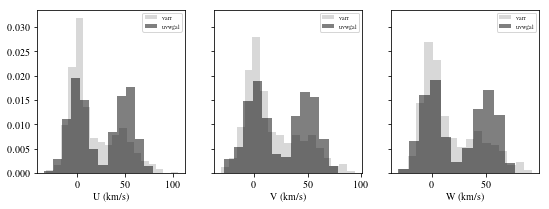

Perform XD..
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
XD:
logLikelihood: best K = 5, best w = 90.25
amps: [5.10005318e-01 4.89994682e-01 2.27229054e-11 2.56664117e-33
 6.65978699e-73], means: [[ -0.1742385    1.12983924  -0.41246712]
 [ 48.97968679  48.83462027  49.78362077]
 [ 62.83968674  74.92293007  62.64506239]
 [100.10053213 105.26483279  85.37046097]
 [ 97.79265064 112.47209984 120.61562757]], covs: [[[ 8.93587250e+01  3.32000242e+00  4.78247671e+00]
  [ 3.32000242e+00  1.11243490e+02  3.00724283e+00]
  [ 4.78247671e+00  3.00724283e+00  9.69370816e+01]]

 [[ 9.62035216e+01 -3.39738053e+00  3.21555201e-01]
  [-3.39738053e+00  9.30376230e+01  6.56014090e-01]
  [ 3.21555201e-01  6.56014090e-01  9.95990175e+01]]

 [[ 9.02499994e+01  1.77609315e-07 -1.73525697e-07]
  [ 1.77609315e-07  9.02499997e+01 -1.87843560e-08]
  [-1.73525697e-07 -1.87843560e-08  9.02499995e+01]]

 [[ 9.02500000e+01  7.56495575e-29  3.80570535e-29]
  [ 7.56495575e-29  9.02500000e+01  5.03539500e-29]
  [ 3.80570

/software/local/lib64/python2.7/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


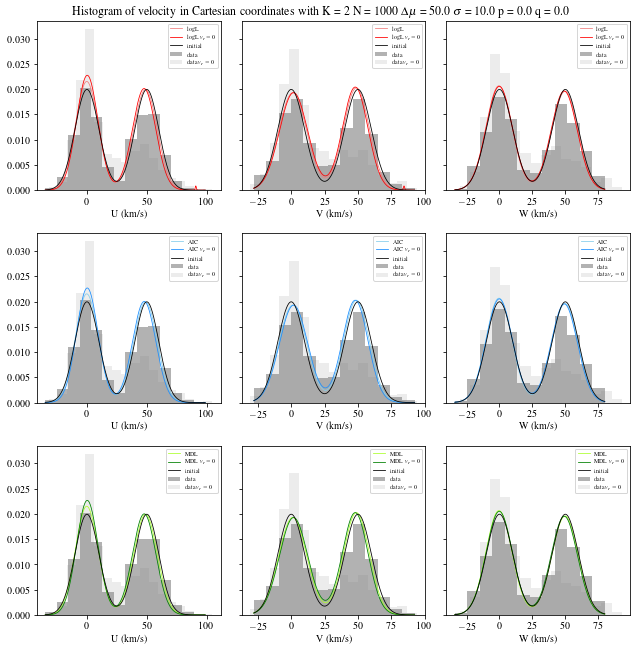

args: (2, 1000, 50.0, 10.0, 0.0, 0.0)


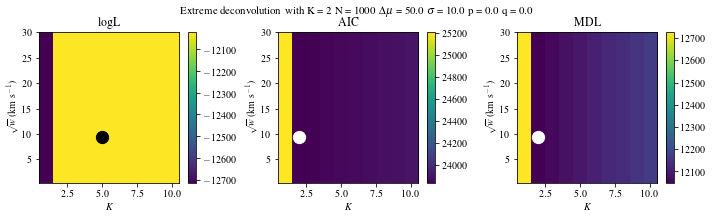

args: (2, 1000, 50.0, 10.0, 0.0, 0.0)


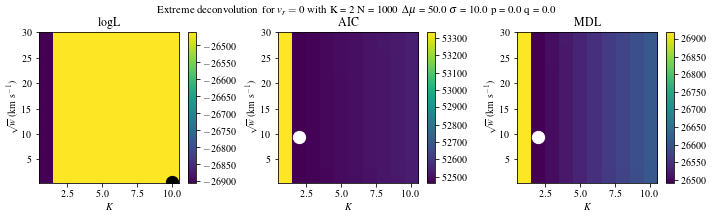

sigma 20.0
[0.5 0.5] [[ 0.  0.  0.]
 [50. 50. 50.]] [[[400.   0.   0.]
  [  0. 400.   0.]
  [  0.   0. 400.]]

 [[400.   0.   0.]
  [  0. 400.   0.]
  [  0.   0. 400.]]]
Transformation to astrometric observables..
Simulate measured values..
Projection..
Transforming to radians for..  ra
Transforming to radians for..  ra
Transforming to radians for..  dec
Transforming to radians for..  dec
w
pqr
R
C
Q
S
UVW
w
pqr
R
C
Q
S
UVW


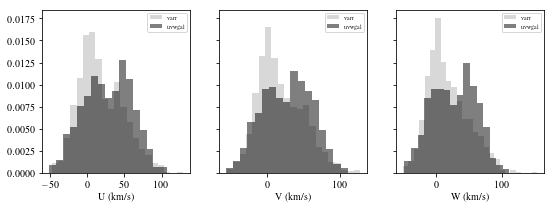

Perform XD..
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
XD:
logLikelihood: best K = 10, best w = 156.25
amps: [4.75506390e-001 4.75021099e-001 3.67441684e-002 1.27283429e-002
 4.80601368e-022 4.56040323e-046 2.27995966e-060 3.17978972e-100
 2.60630182e-148 1.10623679e-204], means: [[  0.99083287   0.50881698  -1.31355963]
 [ 47.35530222  48.20320747  48.82911818]
 [ 69.9554826   73.27302228  56.73402826]
 [ 58.69637132  40.74741369  92.52629447]
 [ 58.02524704  47.37357782  70.97342165]
 [ 58.02524704  47.37357782  70.97342165]
 [ 40.1124387  157.39530157 121.02043109]
 [ 40.12769572 157.44856507 121.08917189]
 [ 40.13878316 157.48727607 121.13913248]
 [ 40.14949157 157.52466679 121.18738987]], covs: [[[ 3.85517247e+002  1.04255710e+001  4.06281437e+001]
  [ 1.04255710e+001  4.58211387e+002  1.83719917e+001]
  [ 4.06281437e+001  1.83719917e+001  3.39214359e+002]]

 [[ 3.75352714e+002 -4.05606730e+001 -2.20019411e+001]
  [-4.05606730e+001  3.87890682e+002  1.85506752e+000]
  [-2.20019411

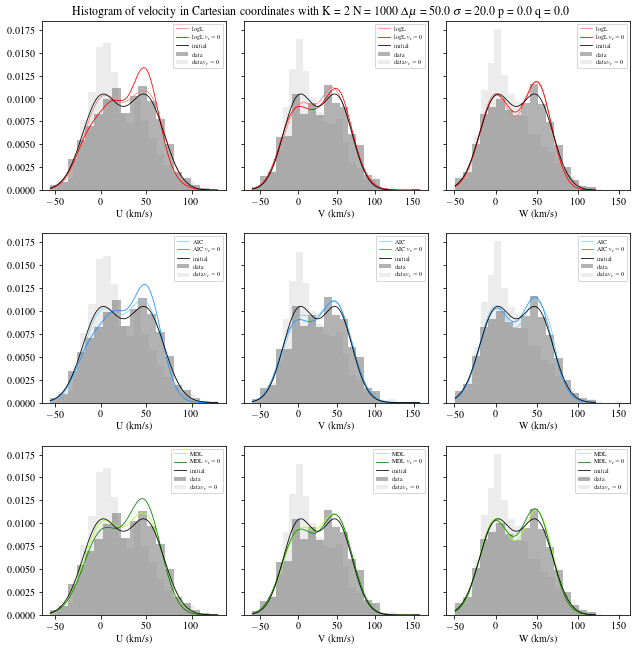

args: (2, 1000, 50.0, 20.0, 0.0, 0.0)


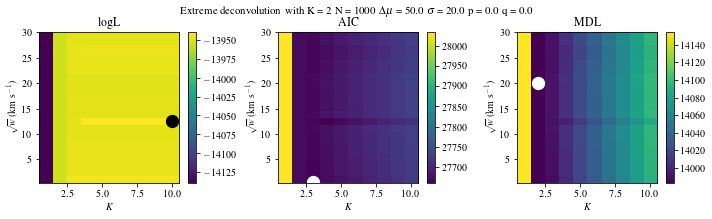

args: (2, 1000, 50.0, 20.0, 0.0, 0.0)


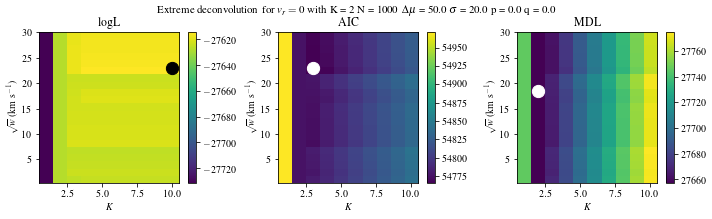

sigma 30.0
[0.5 0.5] [[ 0.  0.  0.]
 [50. 50. 50.]] [[[900.   0.   0.]
  [  0. 900.   0.]
  [  0.   0. 900.]]

 [[900.   0.   0.]
  [  0. 900.   0.]
  [  0.   0. 900.]]]
Transformation to astrometric observables..
Simulate measured values..
Projection..
Transforming to radians for..  ra
Transforming to radians for..  ra
Transforming to radians for..  dec
Transforming to radians for..  dec
w
pqr
R
C
Q
S
UVW
w
pqr
R
C
Q
S
UVW


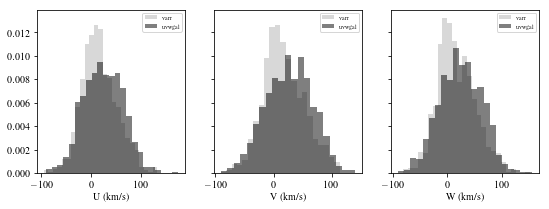

Perform XD..
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
XD:
logLikelihood: best K = 8, best w = 289.0
amps: [0.47786657 0.44537208 0.0494893  0.01670762 0.00465385 0.0032304
 0.00167393 0.00100625], means: [[ -1.07758289  -0.57622529  -2.47290121]
 [ 42.98081613  49.36866821  43.69601939]
 [ 53.47924091  52.68905175  74.20098745]
 [ 90.46978332  72.37995572  31.0716718 ]
 [127.39586311  48.60947182  25.75530691]
 [ 68.94662038  35.95401582 124.14422964]
 [ 36.01194109  64.60361812 147.39305153]
 [168.56934151  60.83836561 111.42983535]], covs: [[[ 907.46894532   15.73086499  -36.77707344]
  [  15.73086499  870.61774878  -62.62943258]
  [ -36.77707344  -62.62943258  803.09051177]]

 [[ 938.52208077  -28.48257215   62.44236634]
  [ -28.48257215  858.87528358  -17.09406202]
  [  62.44236634  -17.09406202  698.8115421 ]]

 [[ 243.3831129   356.34552093  -26.94526215]
  [ 356.34552093  816.27467969   11.06459248]
  [ -26.94526215   11.06459248  101.57187682]]

 [[ 310.2377763   114.16676402 

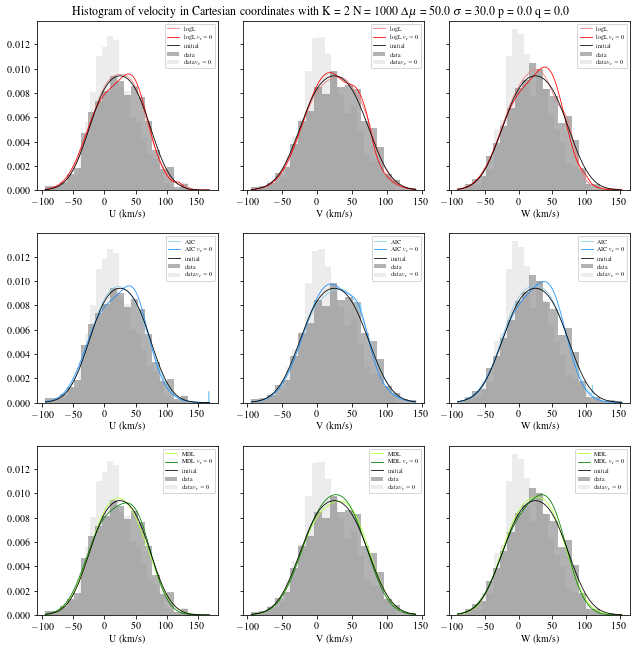

args: (2, 1000, 50.0, 30.0, 0.0, 0.0)


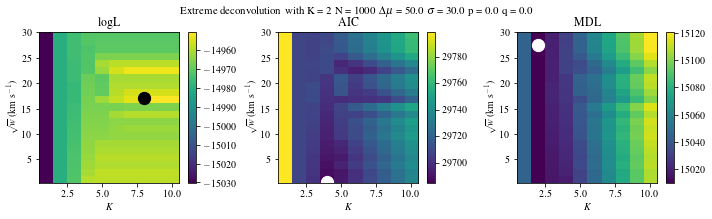

args: (2, 1000, 50.0, 30.0, 0.0, 0.0)


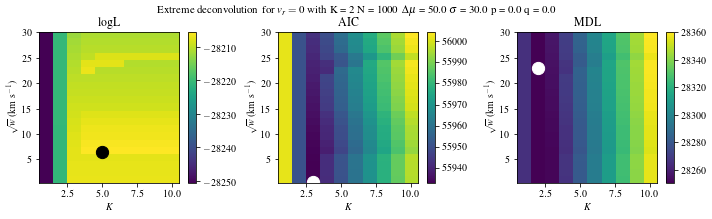

sigma 50.0
[0.5 0.5] [[ 0.  0.  0.]
 [50. 50. 50.]] [[[2500.    0.    0.]
  [   0. 2500.    0.]
  [   0.    0. 2500.]]

 [[2500.    0.    0.]
  [   0. 2500.    0.]
  [   0.    0. 2500.]]]
Transformation to astrometric observables..
Simulate measured values..
Projection..
Transforming to radians for..  ra
Transforming to radians for..  ra
Transforming to radians for..  dec
Transforming to radians for..  dec
w
pqr
R
C
Q
S
UVW
w
pqr
R
C
Q
S
UVW


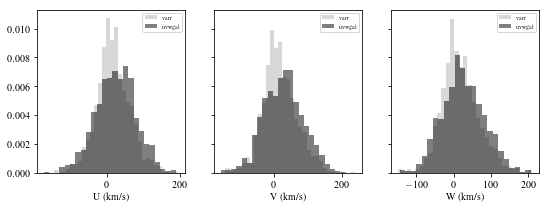

Perform XD..
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
XD:
logLikelihood: best K = 9, best w = 841.0
amps: [4.88799808e-01 3.39613004e-01 5.97762537e-02 4.54663821e-02
 3.97695902e-02 1.56630579e-02 9.89897023e-03 1.01293355e-03
 4.40503114e-10], means: [[ -7.05855974   1.77587784  -2.92308506]
 [ 52.1082486   33.98246845  32.32978818]
 [ 94.68178494  54.60259994  81.06287802]
 [ 36.76003732  88.20548473  92.09035989]
 [ 40.10817182 132.5370226   67.2387975 ]
 [ 26.75964615  41.95501064 150.06923372]
 [ 16.56466366  94.31589092 125.42760931]
 [ 58.49323329 233.5422531  141.51622816]
 [ 36.08777718  37.57707502  76.34383076]], covs: [[[ 2.03253852e+03 -3.45840808e+02 -3.10005224e+02]
  [-3.45840808e+02  2.71303716e+03 -7.94501697e+01]
  [-3.10005224e+02 -7.94501697e+01  2.02792790e+03]]

 [[ 1.28807361e+03 -2.85015060e+02 -6.75772756e+01]
  [-2.85015060e+02  1.81992837e+03 -6.77881674e+02]
  [-6.75772756e+01 -6.77881674e+02  1.63771691e+03]]

 [[ 1.35539477e+03 -7.23840190e+02 -2.960185

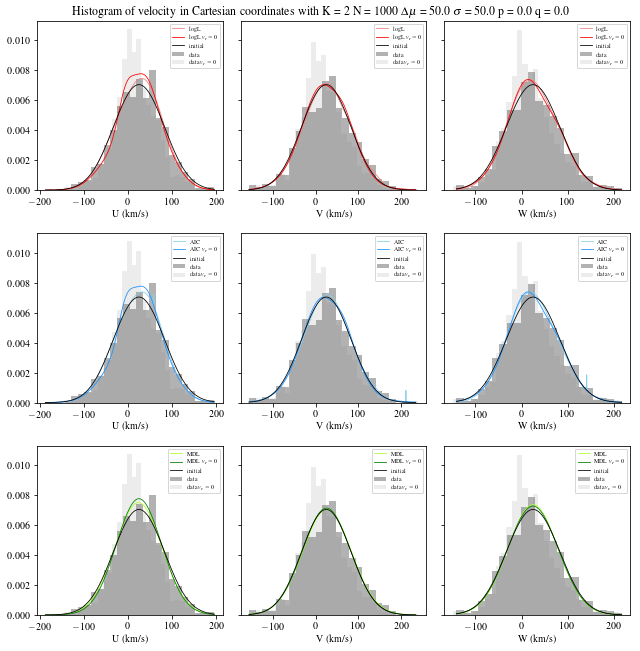

args: (2, 1000, 50.0, 50.0, 0.0, 0.0)


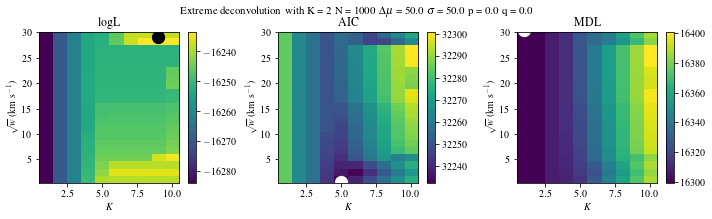

args: (2, 1000, 50.0, 50.0, 0.0, 0.0)


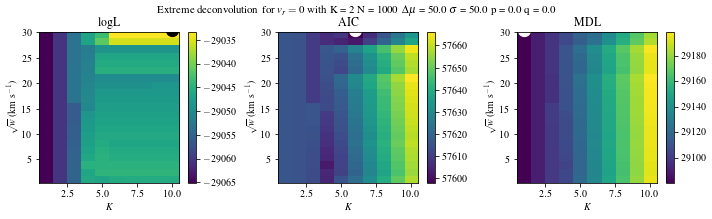

Vary different sigma..
q 0.0
[0.5 0.5] [[ 0.  0.  0.]
 [10. 10. 10.]] [[[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]

 [[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]]
Transformation to astrometric observables..
Simulate measured values..
Projection..
Transforming to radians for..  ra
Transforming to radians for..  ra
Transforming to radians for..  dec
Transforming to radians for..  dec
w
pqr
R
C
Q
S
UVW
w
pqr
R
C
Q
S
UVW


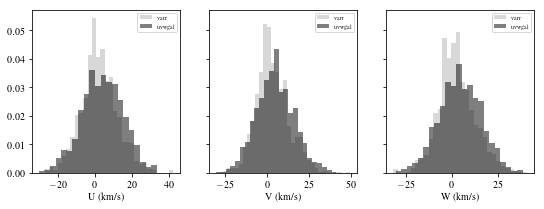

Perform XD..
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
XD:
logLikelihood: best K = 10, best w = 12.25
amps: [5.72652676e-01 2.78826022e-01 7.39432987e-02 4.93044624e-02
 1.20645795e-02 8.29505976e-03 4.91390096e-03 1.16524800e-15
 1.26569719e-28 1.61379335e-43], means: [[-1.79855447  2.28810364 -0.12427193]
 [ 9.3348895   5.46587816  8.14617311]
 [20.99769482  6.13450073 14.37547822]
 [10.59150663 20.37073376 10.65501731]
 [ 6.0699872  21.26614417 22.08943064]
 [16.27928366 13.86415728 28.11495773]
 [13.85581444 28.75819741 27.96078123]
 [ 6.53129634 18.45691838 18.3170443 ]
 [ 6.53129634 18.45691838 18.3170443 ]
 [ 6.53129634 18.45691838 18.3170443 ]], covs: [[[ 7.88842130e+01  9.58046660e+00  5.99030768e+00]
  [ 9.58046660e+00  9.20605492e+01  1.03552998e+01]
  [ 5.99030768e+00  1.03552998e+01  1.00836100e+02]]

 [[ 4.07040502e+01  2.22475871e+01 -3.19401404e+01]
  [ 2.22475871e+01  1.35540614e+02 -5.80099481e+00]
  [-3.19401404e+01 -5.80099481e+00  8.05477777e+01]]

 [[ 1.30605496e+

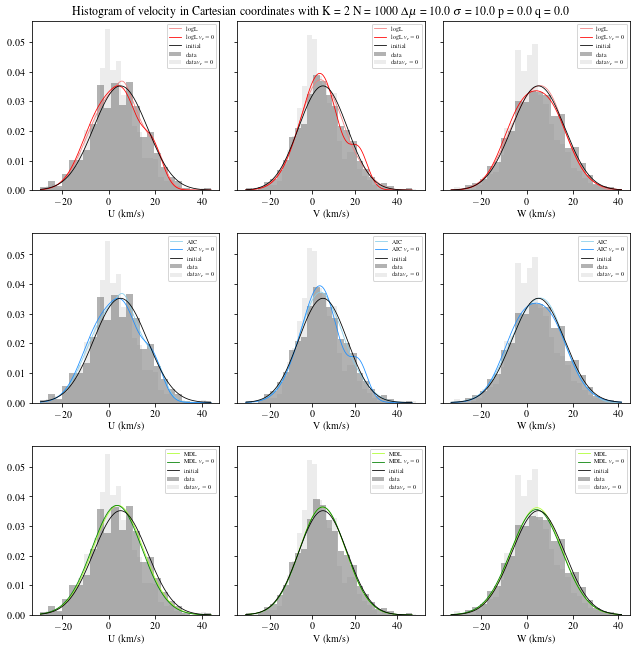

args: (2, 1000, 10.0, 10.0, 0.0, 0.0)


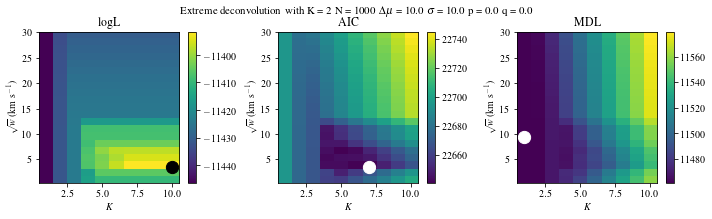

args: (2, 1000, 10.0, 10.0, 0.0, 0.0)


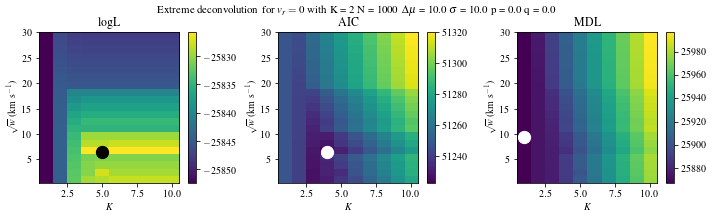

q 0.5
[0.5 0.5] [[ 0.  0.  0.]
 [10. 10. 10.]] [[[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]

 [[ 50.   0.   0.]
  [  0.  50.   0.]
  [  0.   0.  50.]]]
Transformation to astrometric observables..
Simulate measured values..
Projection..
Transforming to radians for..  ra
Transforming to radians for..  ra
Transforming to radians for..  dec
Transforming to radians for..  dec
w
pqr
R
C
Q
S
UVW
w
pqr
R
C
Q
S
UVW


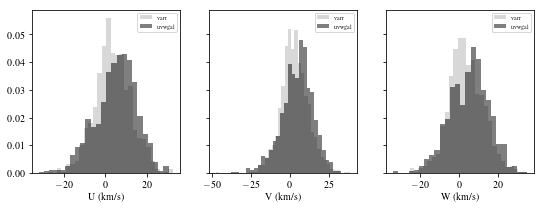

Perform XD..
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
XD:
logLikelihood: best K = 10, best w = 25.0
amps: [4.88218610e-01 4.25844793e-01 7.99303697e-02 3.89366712e-03
 1.13578653e-03 9.76773849e-04 1.64080562e-28 2.88280415e-46
 4.54037463e-68 3.48532401e-94], means: [[  9.52629214   7.55700796   9.34555218]
 [ -1.18437536  -1.1241374   -1.60576348]
 [  9.71359922  18.62654191  13.49617624]
 [ -3.06738041 -12.56485092  25.58119749]
 [  9.33564456  31.65515864  19.4540808 ]
 [-20.08097189  13.23865466  28.23321529]
 [-19.4395581   12.91712468  27.77803349]
 [-19.4395581   12.91712468  27.77803349]
 [-19.4395581   12.91712468  27.77803349]
 [-19.4395581   12.91712468  27.77803349]], covs: [[[ 4.96155816e+01  2.23176162e+00 -4.65124846e+00]
  [ 2.23176162e+00  3.99681801e+01 -5.84556148e+00]
  [-4.65124846e+00 -5.84556148e+00  5.26077104e+01]]

 [[ 8.97043372e+01 -6.18762149e+00 -5.68890727e+00]
  [-6.18762149e+00  8.76517727e+01  4.53204794e+00]
  [-5.68890727e+00  4.53204794e+00  7.393

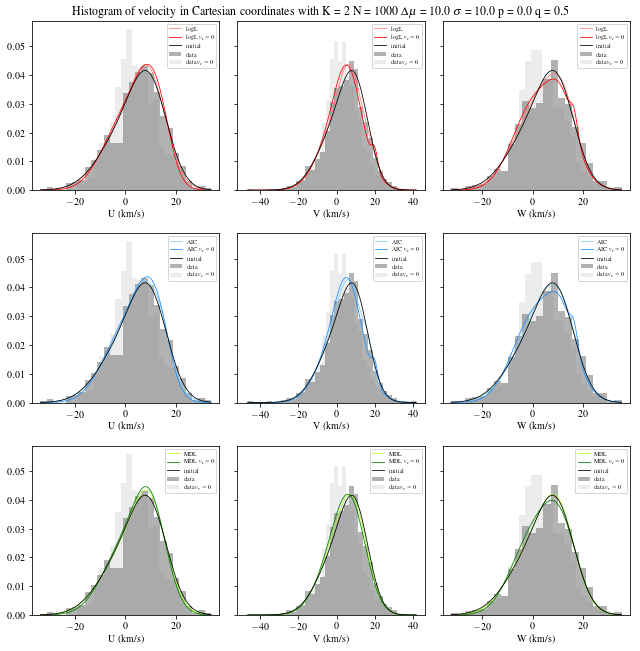

args: (2, 1000, 10.0, 10.0, 0.0, 0.5)


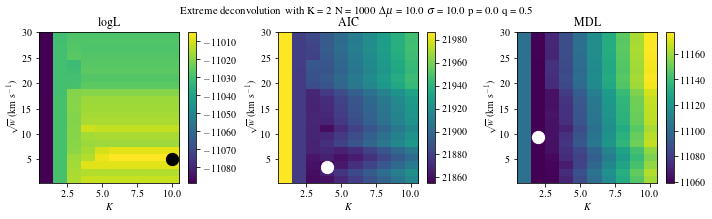

args: (2, 1000, 10.0, 10.0, 0.0, 0.5)


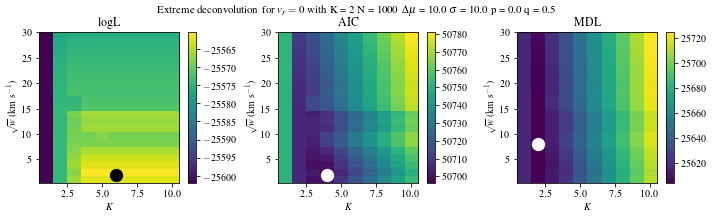

q 1.0
[0.5 0.5] [[ 0.  0.  0.]
 [10. 10. 10.]] [[[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]

 [[ 25.   0.   0.]
  [  0.  25.   0.]
  [  0.   0.  25.]]]
Transformation to astrometric observables..
Simulate measured values..
Projection..
Transforming to radians for..  ra
Transforming to radians for..  ra
Transforming to radians for..  dec
Transforming to radians for..  dec
w
pqr
R
C
Q
S
UVW
w
pqr
R
C
Q
S
UVW


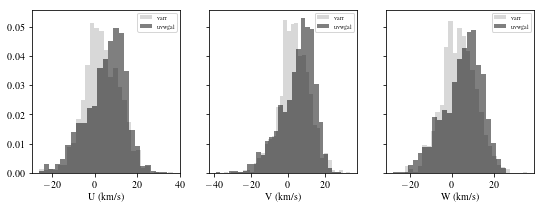

Perform XD..
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
XD:
logLikelihood: best K = 4, best w = 121.0
amps: [0.50802958 0.323745   0.11209224 0.05613319], means: [[ 1.00356600e+01  9.95235648e+00  1.00468038e+01]
 [-1.84662738e+00  5.39226396e-03  2.87745884e+00]
 [ 9.88891241e+00 -8.84076223e-01 -5.82430464e+00]
 [-8.87782591e+00 -5.92922959e-01 -6.93157030e+00]], covs: [[[ 24.30338614   0.99470123   0.62529065]
  [  0.99470123  21.85081283   0.20479905]
  [  0.62529065   0.20479905  25.65881284]]

 [[ 60.59772554   5.732744    -8.08661311]
  [  5.732744    88.44592921  13.08355405]
  [ -8.08661311  13.08355405  70.01777705]]

 [[ 69.66952763 -21.32226343  27.05536924]
  [-21.32226343  83.53130398 -27.73688706]
  [ 27.05536924 -27.73688706  66.953622  ]]

 [[ 47.02538491 -46.44094555   3.76121925]
  [-46.44094555 113.95182872   3.08232488]
  [  3.76121925   3.08232488  32.16622824]]]
AIC: best K = 4, best w = 121.0
amps: [0.50802958 0.323745   0.11209224 0.05613319], means: [[ 1.003566

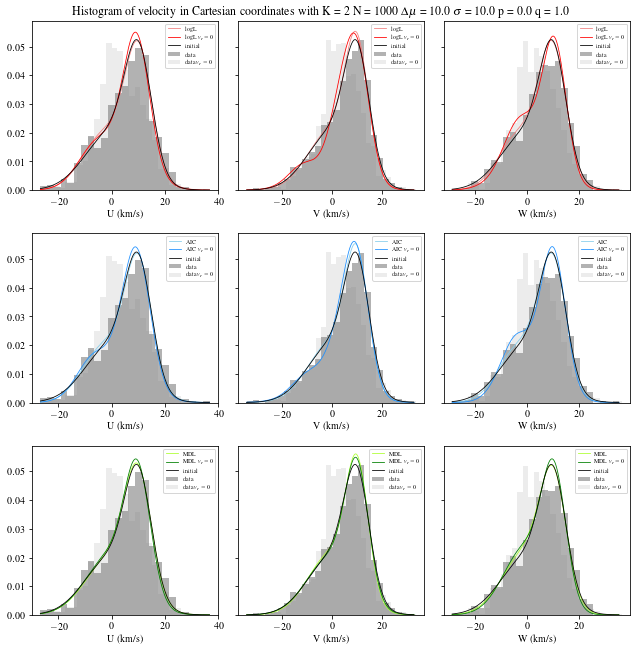

args: (2, 1000, 10.0, 10.0, 0.0, 1.0)


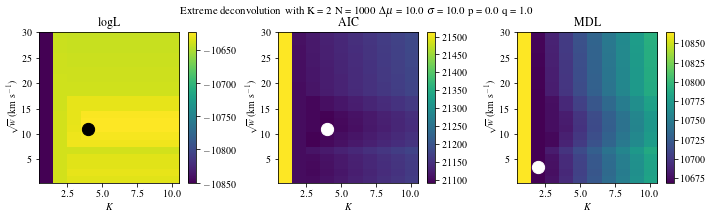

args: (2, 1000, 10.0, 10.0, 0.0, 1.0)


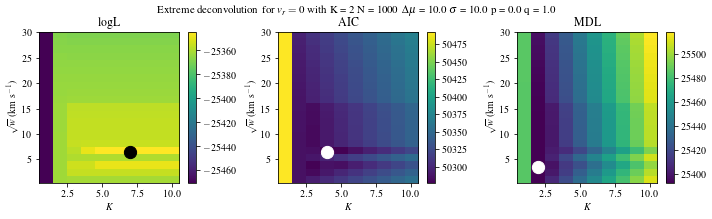

q 2.0
[0.5 0.5] [[ 0.  0.  0.]
 [10. 10. 10.]] [[[100.     0.     0.  ]
  [  0.   100.     0.  ]
  [  0.     0.   100.  ]]

 [[  6.25   0.     0.  ]
  [  0.     6.25   0.  ]
  [  0.     0.     6.25]]]
Transformation to astrometric observables..
Simulate measured values..
Projection..
Transforming to radians for..  ra
Transforming to radians for..  ra
Transforming to radians for..  dec
Transforming to radians for..  dec
w
pqr
R
C
Q
S
UVW
w
pqr
R
C
Q
S
UVW


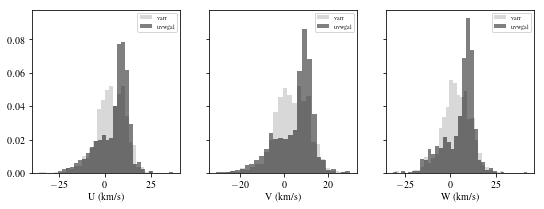

Perform XD..
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
XD:
logLikelihood: best K = 8, best w = 25.0
amps: [4.65725231e-001 4.22965447e-001 9.17560254e-002 1.95532972e-002
 1.38378684e-020 2.39603731e-044 1.42071390e-075 3.06437161e-117], means: [[ -0.07798987  -0.55072591  -0.32871068]
 [  9.76296225  10.04837543   9.66640988]
 [ 11.12757915   8.24166516   9.66067016]
 [ -3.04084032   3.68238542  12.05369086]
 [-11.28559119  -6.74149805  17.84164974]
 [-11.28559136  -6.74149777  17.84165019]
 [-11.2855911   -6.74149819  17.84164952]
 [-11.28558936  -6.74150104  17.84164492]], covs: [[[ 8.66429108e+001 -9.97254202e+000 -1.20783278e+001]
  [-9.97254202e+000  8.64225085e+001 -6.46957090e+000]
  [-1.20783278e+001 -6.46957090e+000  9.28988621e+001]]

 [[ 5.81001404e+000  7.08331341e-001  6.12643794e-001]
  [ 7.08331341e-001  4.65604619e+000  8.47168706e-001]
  [ 6.12643794e-001  8.47168706e-001  5.54191312e+000]]

 [[ 1.15041232e+001  6.19631934e-001 -4.58252840e+000]
  [ 6.19631934e-001  1

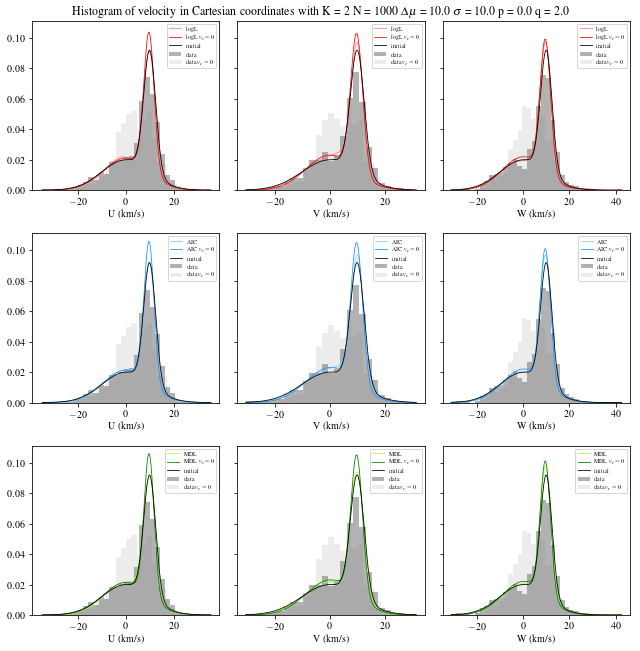

args: (2, 1000, 10.0, 10.0, 0.0, 2.0)


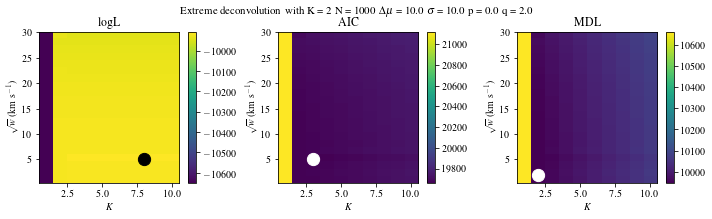

args: (2, 1000, 10.0, 10.0, 0.0, 2.0)


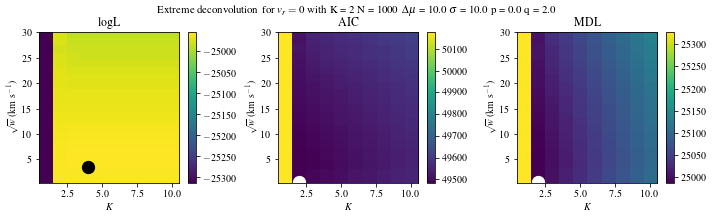

q 3.0
[0.5 0.5] [[ 0.  0.  0.]
 [10. 10. 10.]] [[[100.       0.       0.    ]
  [  0.     100.       0.    ]
  [  0.       0.     100.    ]]

 [[  1.5625   0.       0.    ]
  [  0.       1.5625   0.    ]
  [  0.       0.       1.5625]]]
Transformation to astrometric observables..
Simulate measured values..
Projection..
Transforming to radians for..  ra
Transforming to radians for..  ra
Transforming to radians for..  dec
Transforming to radians for..  dec
w
pqr
R
C
Q
S
UVW
w
pqr
R
C
Q
S
UVW


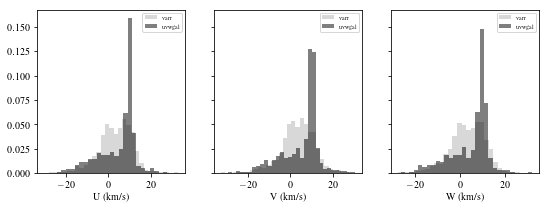

Perform XD..
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
XD:
logLikelihood: best K = 5, best w = 12.25
amps: [5.17096505e-01 4.80972842e-01 1.93065331e-03 5.44128123e-22
 7.57132381e-75], means: [[-0.06442436  1.03102088  0.35275396]
 [ 9.83337491  9.8937284   9.84717611]
 [ 7.92092519 24.39635466 17.98278966]
 [24.52354538  9.4420988  13.66709842]
 [24.48246841  9.58026013 13.79061972]], covs: [[[ 9.69269518e+01 -3.66074498e+00  3.17859221e+00]
  [-3.66074498e+00  9.51792441e+01 -3.71928122e+00]
  [ 3.17859221e+00 -3.71928122e+00  8.75224879e+01]]

 [[ 1.44222447e+00  1.04656830e-01  6.02120046e-02]
  [ 1.04656830e-01  1.62265570e+00 -9.00305062e-02]
  [ 6.02120046e-02 -9.00305062e-02  1.26233615e+00]]

 [[ 5.64546427e+00 -2.05085823e-01 -1.65662858e-02]
  [-2.05085823e-01  5.95091020e+00  5.30249722e-01]
  [-1.65662858e-02  5.30249722e-01  6.45039019e+00]]

 [[ 1.22500000e+01 -5.83035870e-19 -7.46425742e-19]
  [-5.83035870e-19  1.22500000e+01  2.69167406e-18]
  [-7.46425742e-19  2.6916

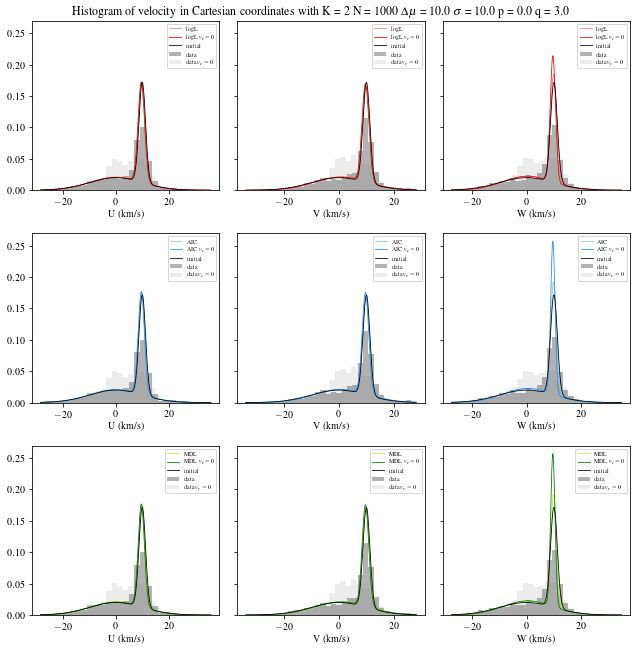

args: (2, 1000, 10.0, 10.0, 0.0, 3.0)


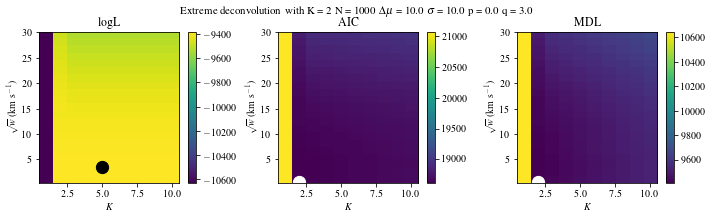

args: (2, 1000, 10.0, 10.0, 0.0, 3.0)


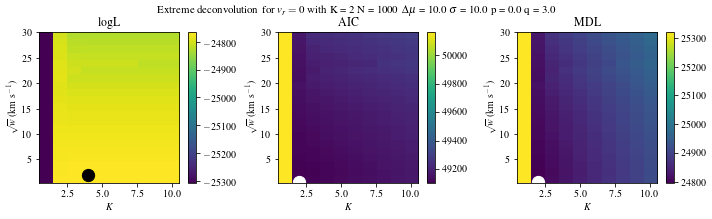

Vary means..
meanstep 10.0
[0.5 0.5] [[ 0.  0.  0.]
 [10. 10. 10.]] [[[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]

 [[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]]
Transformation to astrometric observables..
Simulate measured values..
Projection..
Transforming to radians for..  ra
Transforming to radians for..  ra
Transforming to radians for..  dec
Transforming to radians for..  dec
w
pqr
R
C
Q
S
UVW
w
pqr
R
C
Q
S
UVW


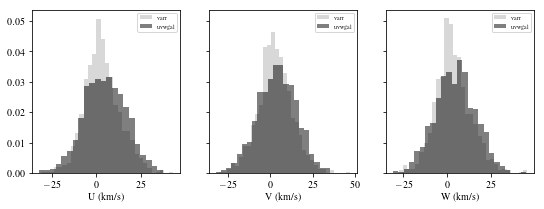

Perform XD..
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
XD:
logLikelihood: best K = 10, best w = 42.25
amps: [5.69412852e-01 1.07128650e-01 9.18570651e-02 7.52289867e-02
 6.85882405e-02 4.38717241e-02 2.66739753e-02 1.47806212e-02
 2.45788422e-03 9.41446956e-11], means: [[-0.29404759 -1.56572647  1.60773506]
 [ 7.41356676 10.79439068  2.52952095]
 [ 5.21126668 11.15269335 18.82956086]
 [15.54041736 12.29184619 16.1094086 ]
 [17.50076429 10.19637979  3.09842339]
 [26.97185946  3.35212863  3.11389965]
 [-5.64888155 16.44587916 -3.41020374]
 [ 8.33412766 26.21952295  6.44498817]
 [17.99152131 29.81555496 -6.03023981]
 [ 4.63913174 14.37767986 -2.72470527]], covs: [[[ 9.73633174e+01 -4.47431268e+00  9.95769071e+00]
  [-4.47431268e+00  8.59027647e+01 -1.46544277e+00]
  [ 9.95769071e+00 -1.46544277e+00  1.10106160e+02]]

 [[ 4.24425852e+01  2.41586614e+01 -1.40081304e+01]
  [ 2.41586614e+01  2.61510735e+01  9.20309933e-01]
  [-1.40081304e+01  9.20309933e-01  6.18193934e+01]]

 [[ 7.21542959e+

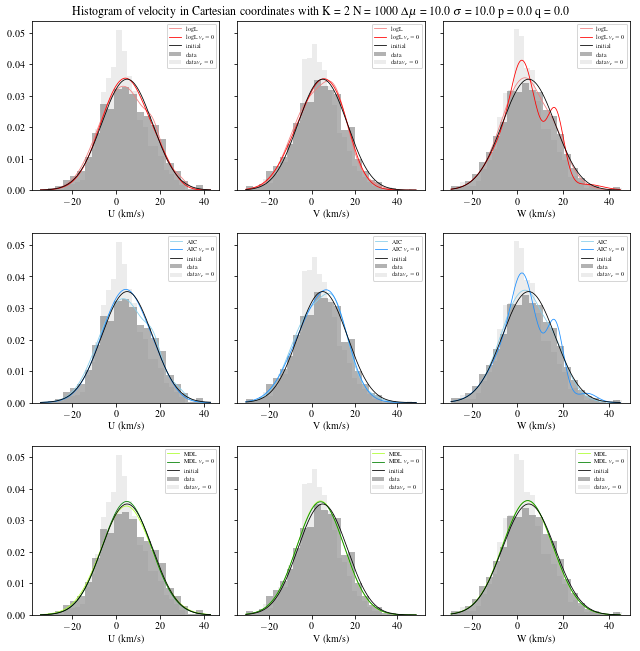

args: (2, 1000, 10.0, 10.0, 0.0, 0.0)


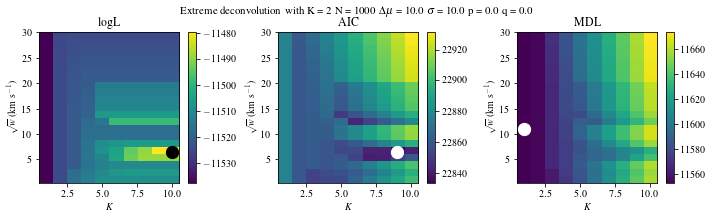

args: (2, 1000, 10.0, 10.0, 0.0, 0.0)


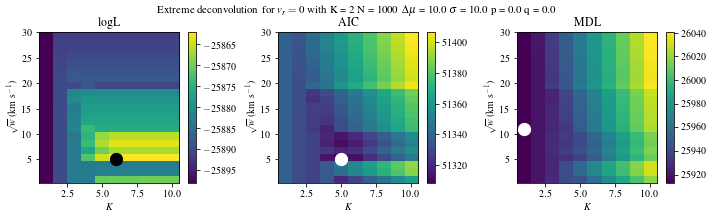

meanstep 20.0
[0.5 0.5] [[ 0.  0.  0.]
 [20. 20. 20.]] [[[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]

 [[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]]
Transformation to astrometric observables..
Simulate measured values..
Projection..
Transforming to radians for..  ra
Transforming to radians for..  ra
Transforming to radians for..  dec
Transforming to radians for..  dec
w
pqr
R
C
Q
S
UVW
w
pqr
R
C
Q
S
UVW


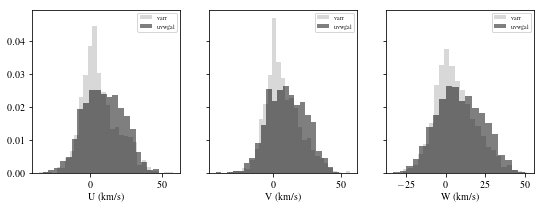

Perform XD..
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
XD:
logLikelihood: best K = 8, best w = 42.25
amps: [5.31678929e-01 2.39059617e-01 1.47842471e-01 6.07439306e-02
 2.06750524e-02 1.01424165e-27 1.96920638e-46 2.97224596e-69], means: [[ 0.27317557  0.67237085 -0.6486312 ]
 [16.22919302 15.59412037 17.90241218]
 [22.02623591 27.39912601 15.39621069]
 [27.18466938 20.15263296 28.13560381]
 [13.21138694 20.3011358  37.34662723]
 [24.03796495 34.73818831 26.0674781 ]
 [24.03796495 34.73818831 26.0674781 ]
 [24.03796495 34.73818831 26.0674781 ]], covs: [[[ 9.61516607e+01 -4.05129653e-01  3.02611116e+00]
  [-4.05129653e-01  9.11676359e+01  1.44512690e+00]
  [ 3.02611116e+00  1.44512690e+00  9.21244520e+01]]

 [[ 1.03257040e+02 -3.11432996e+01 -1.50900544e+01]
  [-3.11432996e+01  7.83374772e+01 -2.55344031e+01]
  [-1.50900544e+01 -2.55344031e+01  8.43611026e+01]]

 [[ 6.19195601e+01  8.41108452e+00 -4.07571291e+00]
  [ 8.41108452e+00  5.71991876e+01  2.87368066e+01]
  [-4.07571291e+00  2.

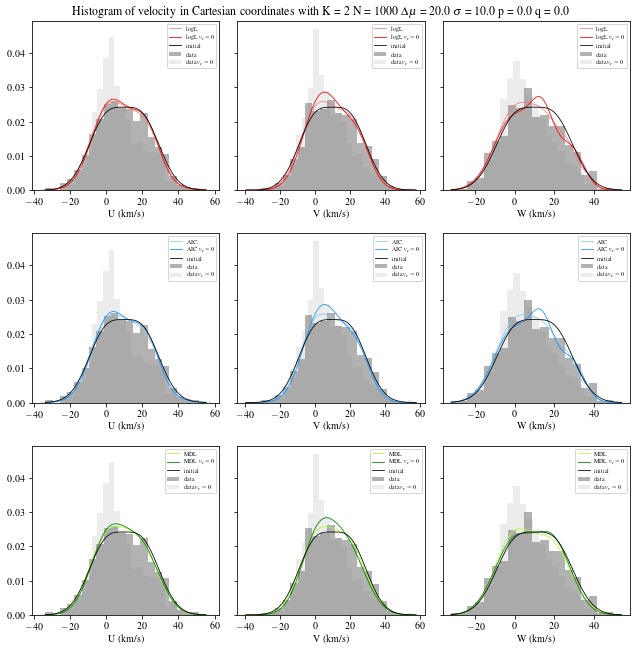

args: (2, 1000, 20.0, 10.0, 0.0, 0.0)


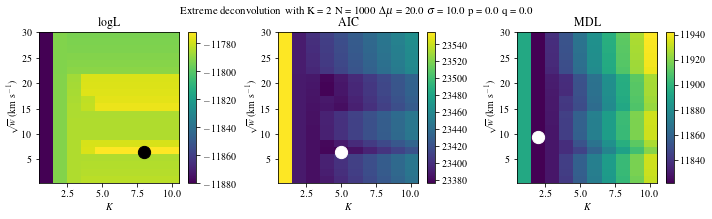

args: (2, 1000, 20.0, 10.0, 0.0, 0.0)


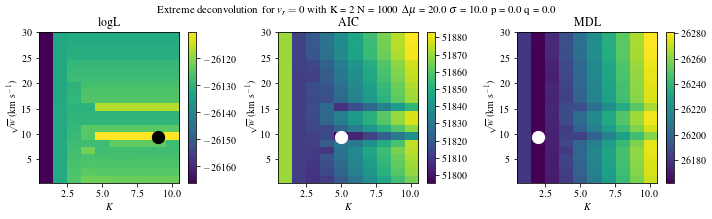

meanstep 30.0
[0.5 0.5] [[ 0.  0.  0.]
 [30. 30. 30.]] [[[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]

 [[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]]
Transformation to astrometric observables..
Simulate measured values..
Projection..
Transforming to radians for..  ra
Transforming to radians for..  ra
Transforming to radians for..  dec
Transforming to radians for..  dec
w
pqr
R
C
Q
S
UVW
w
pqr
R
C
Q
S
UVW


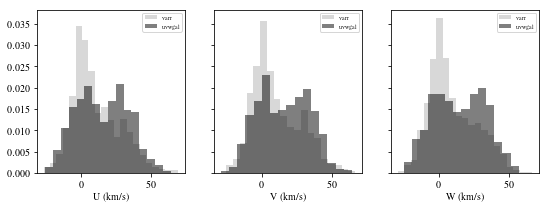

Perform XD..
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
XD:
logLikelihood: best K = 6, best w = 64.0
amps: [5.06747741e-01 4.72562225e-01 1.88385822e-02 1.85145236e-03
 6.68202026e-28 2.32469191e-56], means: [[ 0.19885019  0.81443298 -0.17287846]
 [29.53466624 29.2053263  28.46223741]
 [30.57483272 30.14978615 50.42470248]
 [71.51358429 36.93581305 39.5362397 ]
 [47.08206195 39.11734611 35.6850704 ]
 [47.08206195 39.11734611 35.6850704 ]], covs: [[[ 9.44278083e+01  2.00917087e-01 -6.87101037e-01]
  [ 2.00917087e-01  9.24399736e+01  4.38205828e+00]
  [-6.87101037e-01  4.38205828e+00  9.44038798e+01]]

 [[ 9.93584878e+01  9.25794803e+00  4.19517190e+00]
  [ 9.25794803e+00  9.05983334e+01 -1.32159266e+00]
  [ 4.19517190e+00 -1.32159266e+00  7.16129111e+01]]

 [[ 1.41826296e+02 -5.15358328e+01  9.52500949e-01]
  [-5.15358328e+01  1.58997222e+02 -6.10787312e+00]
  [ 9.52500949e-01 -6.10787312e+00  1.52549856e+01]]

 [[ 4.30659934e+01  6.43094815e+00 -2.15036849e+00]
  [ 6.43094815e+00  3.507

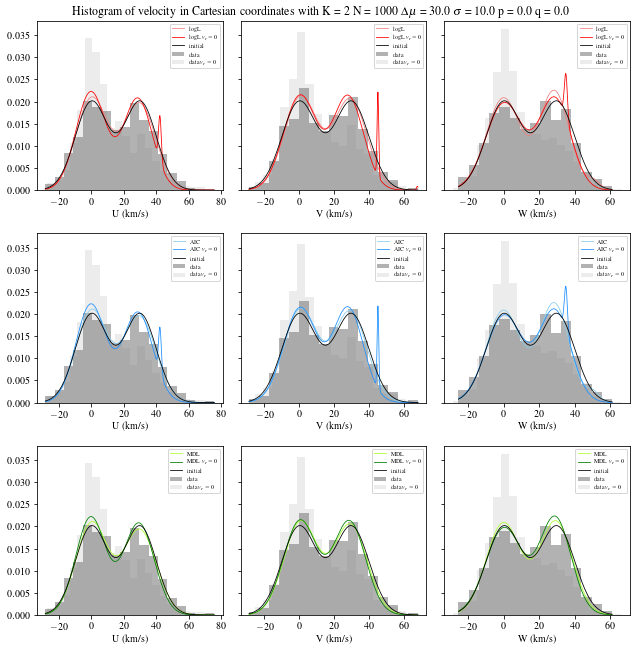

args: (2, 1000, 30.0, 10.0, 0.0, 0.0)


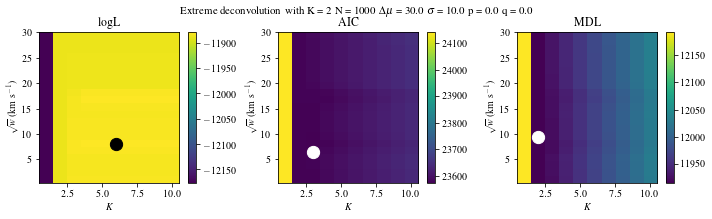

args: (2, 1000, 30.0, 10.0, 0.0, 0.0)


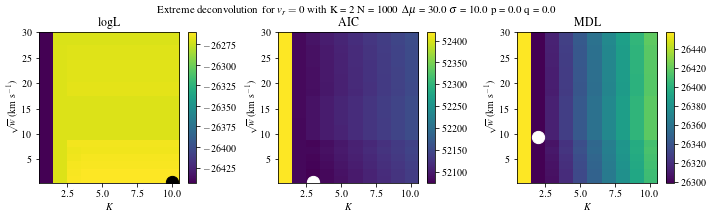

meanstep 50.0
[0.5 0.5] [[ 0.  0.  0.]
 [50. 50. 50.]] [[[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]

 [[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]]
Transformation to astrometric observables..
Simulate measured values..
Projection..
Transforming to radians for..  ra
Transforming to radians for..  ra
Transforming to radians for..  dec
Transforming to radians for..  dec
w
pqr
R
C
Q
S
UVW
w
pqr
R
C
Q
S
UVW


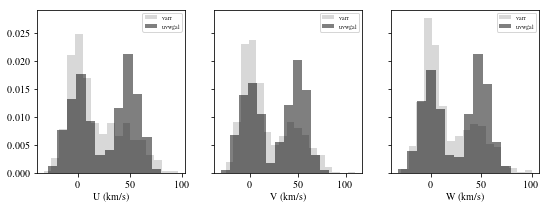

Perform XD..
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
XD:
logLikelihood: best K = 4, best w = 0.25
amps: [5.26135203e-001 4.73002035e-001 8.62761631e-004 1.08069700e-228], means: [[ 4.84472161e+01  4.90998853e+01  4.78817846e+01]
 [ 5.50387921e-02  2.46498608e-01 -2.51273356e-01]
 [ 9.78139574e+01  8.99593098e+01  9.20467440e+01]
 [ 1.34812952e+02  1.30873988e+02  1.48271429e+02]], covs: [[[ 9.39301266e+001  3.77538502e-001 -2.74662590e+000]
  [ 3.77538502e-001  9.21806553e+001 -4.22773774e+000]
  [-2.74662590e+000 -4.22773774e+000  8.44300828e+001]]

 [[ 1.03832447e+002 -6.79890629e+000  1.14029544e+000]
  [-6.79890629e+000  1.01913025e+002  2.29780516e+000]
  [ 1.14029544e+000  2.29780516e+000  9.52781261e+001]]

 [[ 1.84737165e-001 -1.51613567e-002  5.39027192e-002]
  [-1.51613567e-002  2.40755097e-001  1.66783509e-002]
  [ 5.39027192e-002  1.66783509e-002  2.02294356e-001]]

 [[ 2.50000000e-001 -3.79094220e-227  1.26705786e-226]
  [-3.79094220e-227  2.50000000e-001  3.73939836e-22

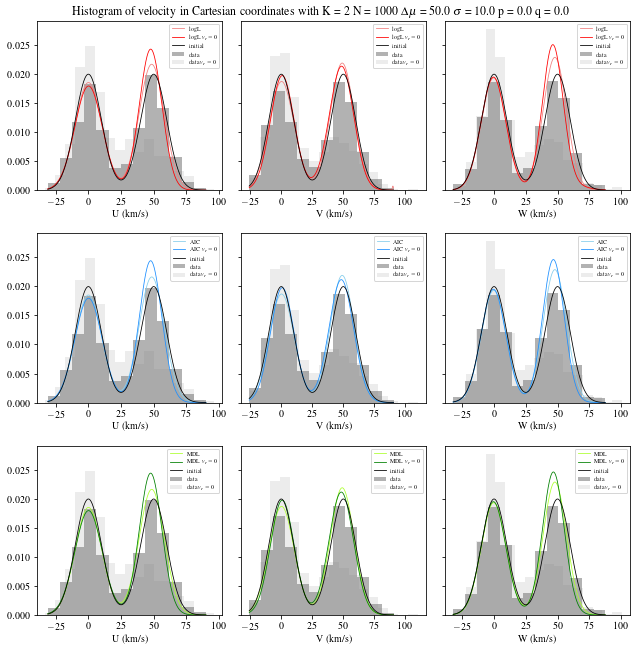

args: (2, 1000, 50.0, 10.0, 0.0, 0.0)


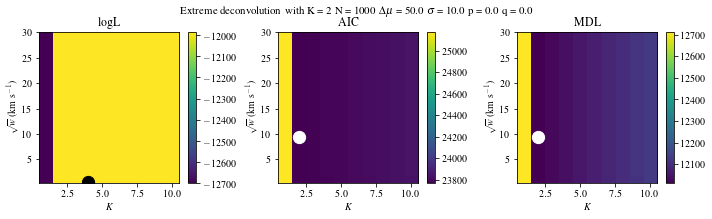

args: (2, 1000, 50.0, 10.0, 0.0, 0.0)


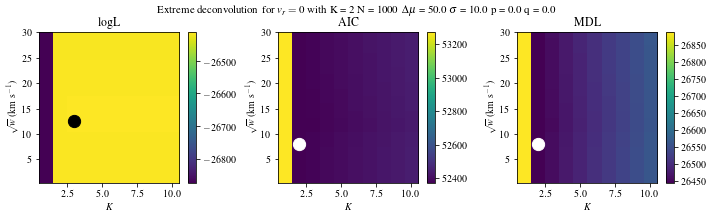

Vary amps..
p 0.0
[0.5 0.5] [[ 0.  0.  0.]
 [25. 25. 25.]] [[[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]

 [[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]]
Transformation to astrometric observables..
Simulate measured values..
Projection..
Transforming to radians for..  ra
Transforming to radians for..  ra
Transforming to radians for..  dec
Transforming to radians for..  dec
w
pqr
R
C
Q
S
UVW
w
pqr
R
C
Q
S
UVW


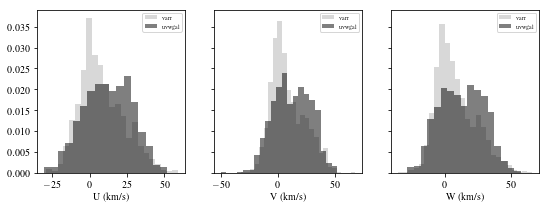

Perform XD..
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
XD:
logLikelihood: best K = 9, best w = 42.25
amps: [4.88469991e-001 3.42181513e-001 8.20761583e-002 8.11975441e-002
 6.07479347e-003 6.44795432e-026 1.33303950e-057 2.12975252e-096
 1.54341909e-142], means: [[-0.36365168 -0.06636421 -0.59373833]
 [23.90407104 28.96889368 23.10241809]
 [16.89037902 18.42111383 30.50308904]
 [28.57988136 10.14477331 25.26810182]
 [37.6624073  25.50231782 44.40815718]
 [28.83628457 21.8016988  42.7422027 ]
 [28.83628457 21.8016988  42.7422027 ]
 [28.83628457 21.8016988  42.7422027 ]
 [28.83628457 21.8016988  42.7422027 ]], covs: [[[ 1.08671457e+002  4.35070310e+000 -8.34632744e+000]
  [ 4.35070310e+000  1.00174608e+002 -5.99084267e-001]
  [-8.34632744e+000 -5.99084267e-001  8.82562776e+001]]

 [[ 8.64202265e+001 -4.71908301e+000 -1.37928382e+001]
  [-4.71908301e+000  5.28031019e+001  6.34106056e+000]
  [-1.37928382e+001  6.34106056e+000  8.33157614e+001]]

 [[ 3.12540778e+001  2.83981498e+001  2.4616

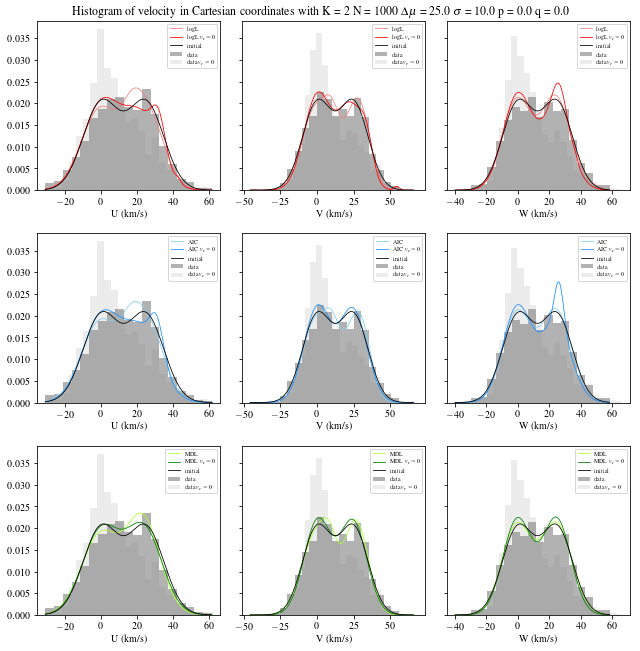

args: (2, 1000, 25.0, 10.0, 0.0, 0.0)


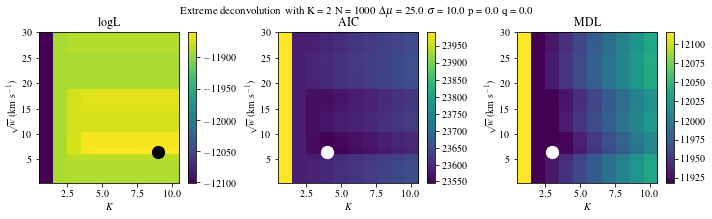

args: (2, 1000, 25.0, 10.0, 0.0, 0.0)


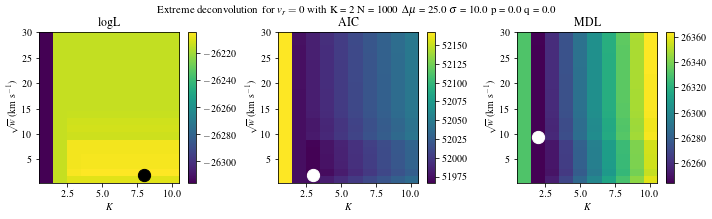

p 0.5
[0.35355339 0.64644661] [[ 0.  0.  0.]
 [25. 25. 25.]] [[[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]

 [[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]]
Transformation to astrometric observables..
Simulate measured values..
Projection..
Transforming to radians for..  ra
Transforming to radians for..  ra
Transforming to radians for..  dec
Transforming to radians for..  dec
w
pqr
R
C
Q
S
UVW
w
pqr
R
C
Q
S
UVW


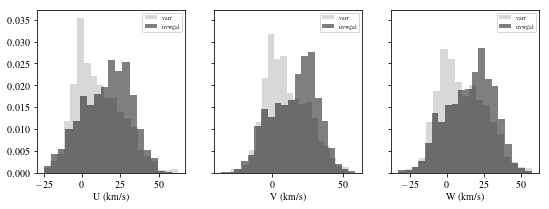

Perform XD..
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
XD:
logLikelihood: best K = 4, best w = 0.25
amps: [0.61347542 0.35970649 0.02585347 0.00096462], means: [[24.58781332 23.96325594 23.58673145]
 [ 0.11892807 -0.73293862 -0.26212358]
 [23.60535781 34.98172222 38.96092251]
 [51.3359926  74.82297782 52.18622404]], covs: [[[ 1.00841652e+02  1.01840750e+00  7.00564325e+00]
  [ 1.01840750e+00  9.70046167e+01 -3.66026454e+00]
  [ 7.00564325e+00 -3.66026454e+00  8.81511536e+01]]

 [[ 9.22227660e+01  4.46505498e+00 -5.70913755e+00]
  [ 4.46505498e+00  9.88936815e+01  6.79790253e+00]
  [-5.70913755e+00  6.79790253e+00  1.02886362e+02]]

 [[ 2.65573253e+01  7.29399574e+00  1.33053215e+01]
  [ 7.29399574e+00  1.13852417e+01 -2.08461775e+01]
  [ 1.33053215e+01 -2.08461775e+01  7.19957737e+01]]

 [[ 1.91115240e-01  5.92217269e-02  1.36603743e-02]
  [ 5.92217269e-02  1.86791613e-01 -1.00963427e-02]
  [ 1.36603743e-02 -1.00963427e-02  2.42239490e-01]]]
AIC: best K = 3, best w = 0.25
amps: [0.6160

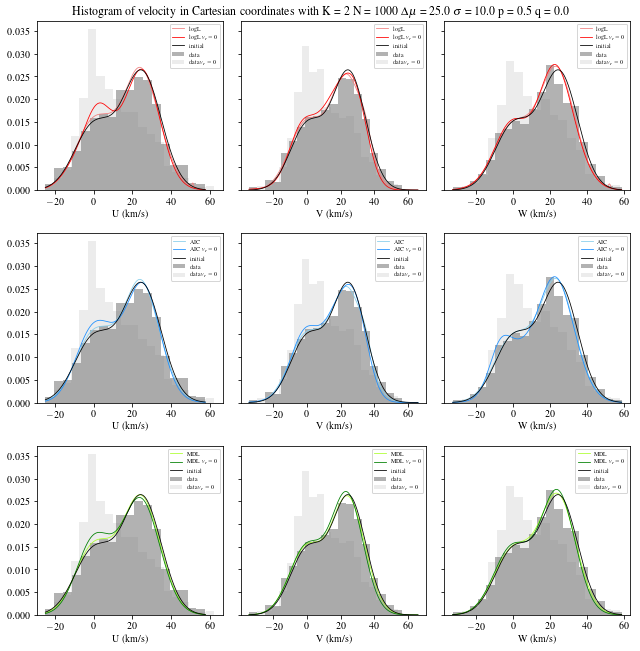

args: (2, 1000, 25.0, 10.0, 0.5, 0.0)


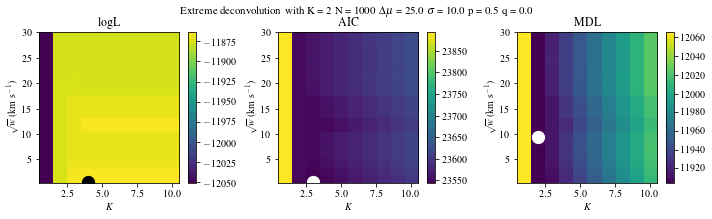

args: (2, 1000, 25.0, 10.0, 0.5, 0.0)


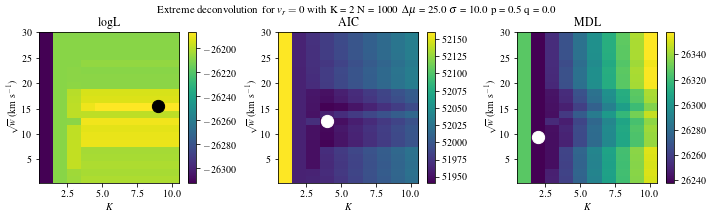

p 1.0
[0.25 0.75] [[ 0.  0.  0.]
 [25. 25. 25.]] [[[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]

 [[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]]
Transformation to astrometric observables..
Simulate measured values..
Projection..
Transforming to radians for..  ra
Transforming to radians for..  ra
Transforming to radians for..  dec
Transforming to radians for..  dec
w
pqr
R
C
Q
S
UVW
w
pqr
R
C
Q
S
UVW


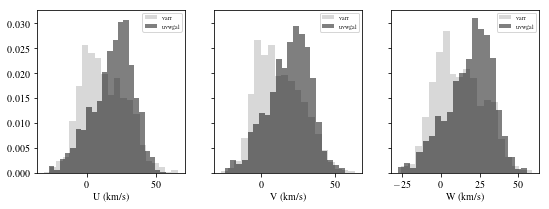

Perform XD..
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
XD:
logLikelihood: best K = 10, best w = 25.0
amps: [7.45204231e-001 2.47116467e-001 3.99932781e-003 3.67997343e-003
 2.73110926e-038 2.17550069e-071 2.56127088e-113 8.31588293e-165
 2.71490353e-226 4.75388214e-296], means: [[24.49998041 24.15008432 24.52603814]
 [-0.73896958  0.84681579 -0.51598606]
 [39.02813022 55.12448079 30.58506567]
 [11.26028398 55.99119889 42.2876023 ]
 [38.62838272 56.73663654 41.23325796]
 [38.62896462 56.73680125 41.23357496]
 [38.62936764 56.73691532 41.23379451]
 [38.62984121 56.73704935 41.23405251]
 [38.6303806  56.73720199 41.23434639]
 [38.63093841 56.73735982 41.2346503 ]], covs: [[[ 9.11804702e+001  3.69173027e+000  1.59529441e+000]
  [ 3.69173027e+000  8.96652756e+001 -5.58935819e+000]
  [ 1.59529441e+000 -5.58935819e+000  9.01059280e+001]]

 [[ 8.76317633e+001  1.33096272e+001  1.34713533e+001]
  [ 1.33096272e+001  8.07289072e+001 -8.30488525e-001]
  [ 1.34713533e+001 -8.30488525e-001  1.036982

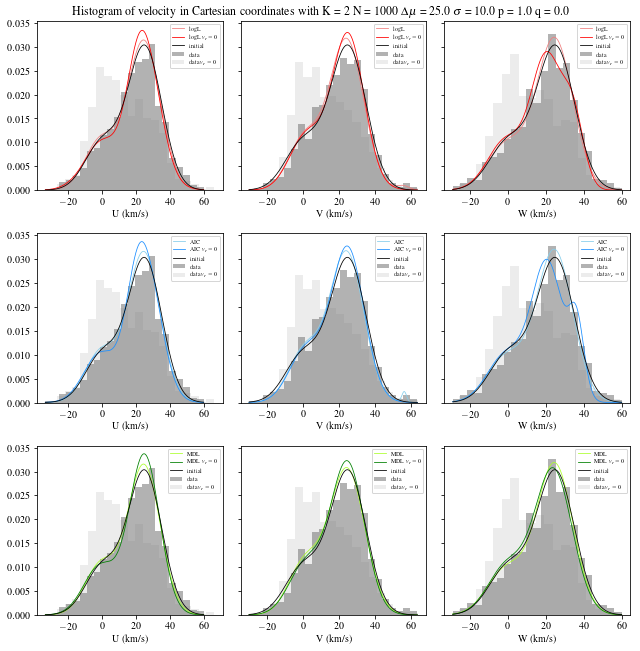

args: (2, 1000, 25.0, 10.0, 1.0, 0.0)


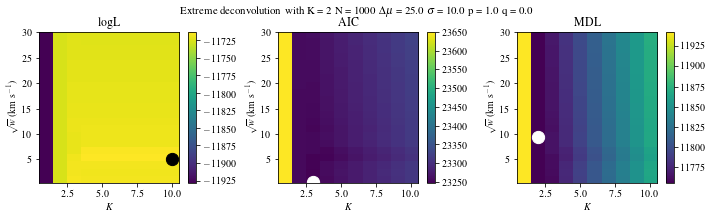

args: (2, 1000, 25.0, 10.0, 1.0, 0.0)


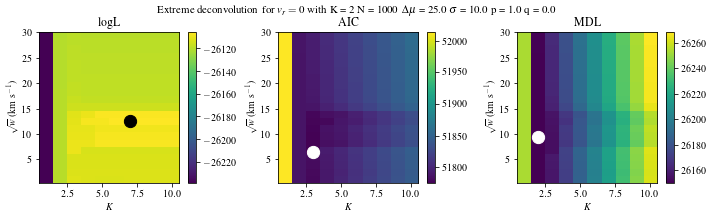

p 2.0
[0.125 0.875] [[ 0.  0.  0.]
 [25. 25. 25.]] [[[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]

 [[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]]
Transformation to astrometric observables..
Simulate measured values..
Projection..
Transforming to radians for..  ra
Transforming to radians for..  ra
Transforming to radians for..  dec
Transforming to radians for..  dec
w
pqr
R
C
Q
S
UVW
w
pqr
R
C
Q
S
UVW


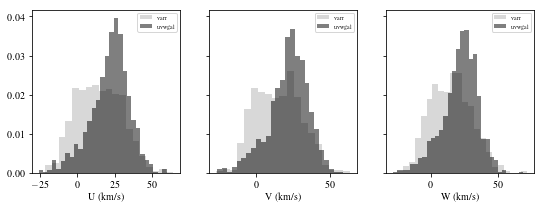

Perform XD..
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
XD:
logLikelihood: best K = 6, best w = 0.25
amps: [8.58130815e-001 1.33896076e-001 7.97310857e-003 3.16398045e-090
 5.38343157e-220 0.00000000e+000], means: [[ 24.28024388  24.45657219  24.30352375]
 [ -0.26592857  -0.38776039   1.08919269]
 [ 35.27970223  37.56011454  41.94288222]
 [ 52.62244007  69.96782131  60.62508149]
 [ 57.4206918  106.64367166  84.52253051]
 [ 70.80364986 130.16831711 107.42874587]], covs: [[[ 8.49318852e+001 -3.14815865e+000 -2.88392644e+000]
  [-3.14815865e+000  9.50032539e+001 -3.71100353e+000]
  [-2.88392644e+000 -3.71100353e+000  9.38869154e+001]]

 [[ 8.84114727e+001 -4.09169682e+000 -9.30504821e-001]
  [-4.09169682e+000  9.25432271e+001  8.98623471e+000]
  [-9.30504821e-001  8.98623471e+000  1.18195575e+002]]

 [[ 5.23055671e+000  2.42611611e+001 -2.95720189e+001]
  [ 2.42611611e+001  1.16064907e+002 -1.41343468e+002]
  [-2.95720189e+001 -1.41343468e+002  1.72549611e+002]]

 [[ 2.50000000e-001 -3.186

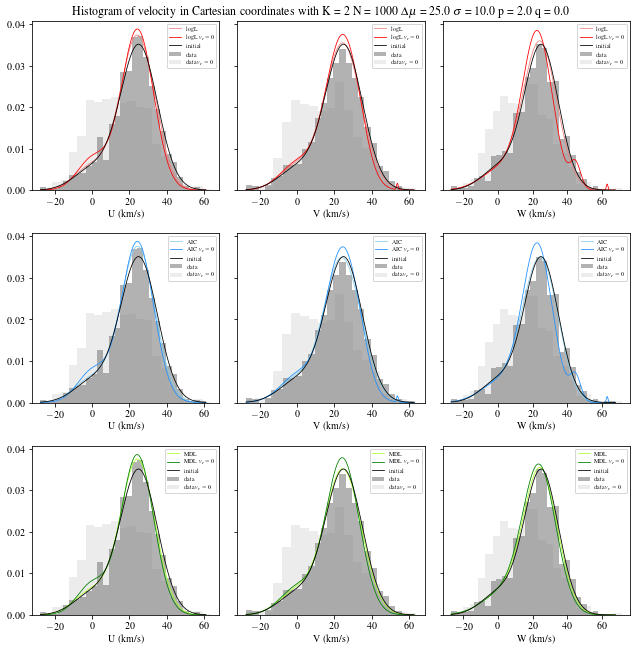

args: (2, 1000, 25.0, 10.0, 2.0, 0.0)


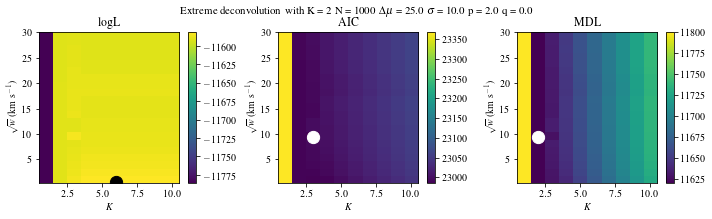

args: (2, 1000, 25.0, 10.0, 2.0, 0.0)


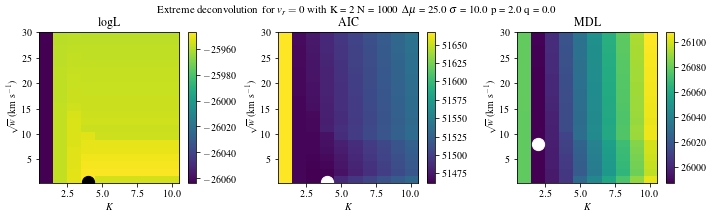

p 3.0
[0.0625 0.9375] [[ 0.  0.  0.]
 [25. 25. 25.]] [[[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]

 [[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]]
Transformation to astrometric observables..
Simulate measured values..
Projection..
Transforming to radians for..  ra
Transforming to radians for..  ra
Transforming to radians for..  dec
Transforming to radians for..  dec
w
pqr
R
C
Q
S
UVW
w
pqr
R
C
Q
S
UVW


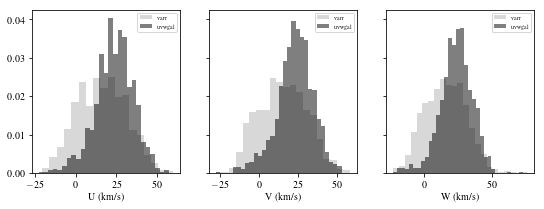

Perform XD..
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
XD:
logLikelihood: best K = 3, best w = 0.25
amps: [0.90997015 0.07121168 0.01881817], means: [[ 2.49537777e+01  2.39312090e+01  2.44822326e+01]
 [ 1.33169970e+00 -8.85418439e-03  1.91204412e+00]
 [ 2.89827466e+01  3.73487377e+01  3.73446354e+01]], covs: [[[  90.60166179  -10.63746297   -6.51440085]
  [ -10.63746297   84.32635695    1.71290643]
  [  -6.51440085    1.71290643   94.30794782]]

 [[  84.55117074   -0.30059954   11.40252177]
  [  -0.30059954   97.1147299     6.69626876]
  [  11.40252177    6.69626876  163.32081783]]

 [[  82.91003719   55.71691442 -127.23441857]
  [  55.71691442   53.13395355  -86.93487592]
  [-127.23441857  -86.93487592  195.72571564]]]
AIC: best K = 3, best w = 0.25
amps: [0.90997015 0.07121168 0.01881817], means: [[ 2.49537777e+01  2.39312090e+01  2.44822326e+01]
 [ 1.33169970e+00 -8.85418439e-03  1.91204412e+00]
 [ 2.89827466e+01  3.73487377e+01  3.73446354e+01]], covs: [[[  90.60166179  -10.6374629

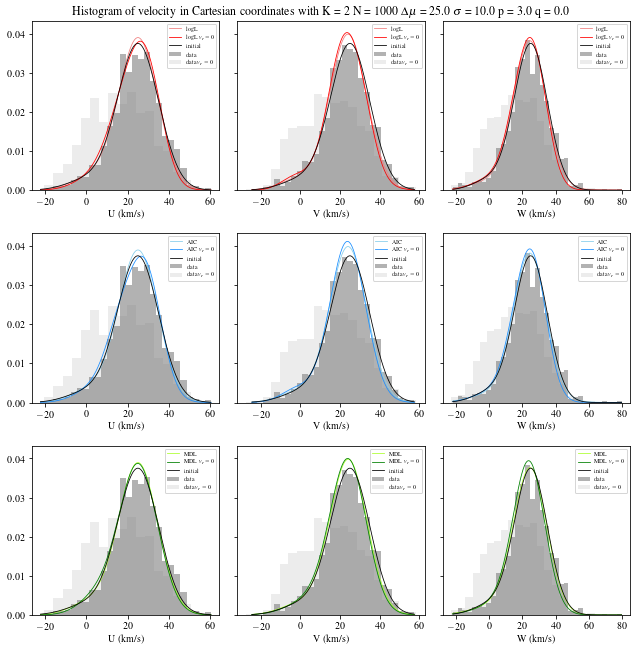

args: (2, 1000, 25.0, 10.0, 3.0, 0.0)


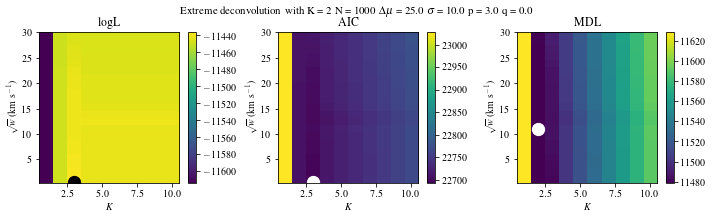

args: (2, 1000, 25.0, 10.0, 3.0, 0.0)


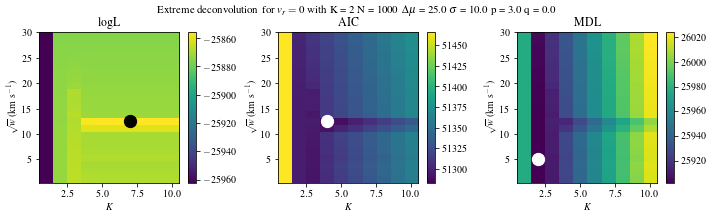

In [2]:
meanstepvary = [10., 20., 30., 50.] #km/s
sigmavary = [10., 20., 30., 50.] #km/s
pvary = [0., .5, 1., 2., 3.] #relation between amplitudes of components
qvary = [0., .5, 1., 2., 3.] #relation between sigmas of components

print "Vary same sigma.."
for i in sigmavary:
    print "sigma", i
    total_simulation(50., i, 0., 0.)

print "Vary different sigma.."
for i in qvary:
    print "q", i
    total_simulation(10., 10., 0., i)

print "Vary means.."
for i in meanstepvary:
    print "meanstep", i
    total_simulation(i, 10., 0., 0.)

print "Vary amps.."
for i in pvary:
    print "p", i
    total_simulation(25., 10., i, 0.)